In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
from torch_geometric.data import HeteroData
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import HANConv
import torch.optim as optim

In [3]:
# Using GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
music = pd.read_csv("music.csv")
music.head()

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [5]:
print(music.shape[0])
music.info()

10000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist.hotttnesss          10000 non-null  float64
 1   artist.id                  10000 non-null  object 
 2   artist.name                10000 non-null  object 
 3   artist_mbtags              3711 non-null   object 
 4   artist_mbtags_count        10000 non-null  float64
 5   bars_confidence            10000 non-null  float64
 6   bars_start                 10000 non-null  float64
 7   beats_confidence           10000 non-null  float64
 8   beats_start                10000 non-null  float64
 9   duration                   10000 non-null  float64
 10  end_of_fade_in             10000 non-null  float64
 11  familiarity                9996 non-null   float64
 12  key                        10000 non-null  float64
 13  key_confidence             10000 non-null

### Data Cleaning

In [6]:
print(music[music.isna().any(axis=1)].shape[0])
music[music.isna().any(axis=1)].head(5)

7717


,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [7]:
music = music.drop(columns=['artist_mbtags','song.hotttnesss'])
music[music.isna().any(axis=1)]

,artist.hotttnesss,artist.id,artist.name,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
752,0.000000,ARVNIVQ1250941026F,Dylan Kuo,0.00000,0.30600,1.59658,0.872,0.39238,230.29506,0.289,...,221.304,0.73700,0.39238,100.173,NaN,0.0,4.000,0.531,Ji Xiang Yan Chu,0
1004,0.384203,AR2D6TV1187B9B2FBF,FIR,0.00000,0.10300,0.09522,0.000,0.09522,206.57587,0.000,...,191.199,0.37400,0.09522,122.041,NaN,0.0,3.000,0.656,Lydia [Piano Version],0
2835,0.420703,ARDXGVT124207832C0,Twinkle Twinkle Little Rock Star,0.00000,0.58600,0.36694,0.495,0.36694,235.38893,0.000,...,228.095,0.99900,0.36694,85.508,NaN,0.0,3.000,1.000,Jamming,0
2950,0.420703,ARDXGVT124207832C0,Twinkle Twinkle Little Rock Star,0.00000,0.15900,0.75800,0.673,0.75800,238.52363,0.000,...,229.866,0.50300,0.38939,80.003,NaN,0.0,4.000,0.000,A Dustland Fairytale,0
3064,0.000000,ARKWXGS11F4C8419B7,Jesus Otero - Luny Tunes,0.00000,0.00300,1.35586,0.594,0.71580,191.76444,0.000,...,191.764,0.30200,0.23364,96.024,requiem,1.0,4.000,0.698,Nivel De Mafia,0
3610,0.000000,ARPWMGF1269FB25878,Yiannis Tassios,0.00000,0.25900,0.20197,0.136,0.20197,208.11710,0.000,...,203.848,0.88000,0.04342,190.035,greek,1.0,4.000,0.978,Ti Patheno,0
4381,0.000000,AROHUUU1269FB35937,Melanie And The Secret Army,0.00000,0.20900,0.83845,0.790,0.40411,255.58159,0.559,...,247.049,0.41400,0.19324,144.319,oi,1.0,4.000,0.386,Held Der Tastatur,0
6348,0.304246,AR7QL2911C8A416805,GAPteborgs Symfoniker / Neeme JA$?rvi,8.85524,8.85524,1.00000,0.000,-60.00000,22050.00000,0.000,...,-21.394,9.22756,0.00000,1.000,Russian Easter Festival_ Overture_ Op.36,2239217.0,0.428,898.891,94496,0
6763,0.284359,ARLOVHG1187FB39692,SA(c)bastien Roch,0.00000,0.08300,0.23377,0.932,0.23377,184.08444,5.079,...,175.502,0.40200,0.23377,126.103,french pop,1.0,4.000,0.260,NaN,0
8744,0.000000,AROHUUU1269FB35937,Melanie And The Secret Army,0.00000,0.00200,0.69235,1.000,0.14843,186.14812,0.340,...,180.518,0.44900,0.14843,110.459,oi,1.0,4.000,1.000,All The Lessons,0


In [8]:
music = music.dropna()
music[music.isna().any(axis=1)]
print(music.shape[0])
music.describe()

9989


,artist.hotttnesss,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,familiarity,key,...,mode_confidence,release.id,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms_freq,time_signature,time_signature_confidence,year
count,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,...,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000
mean,0.385795,0.524377,0.238799,1.065584,0.614011,0.434599,238.467081,0.756694,0.565595,5.277005,...,0.477849,370959.001702,229.934028,0.506941,0.299981,122.914981,0.969179,3.564521,0.509906,935.733907
std,0.143408,0.880489,0.275170,1.724314,0.322405,0.533870,113.999888,1.859318,0.160099,3.553675,...,0.191156,236653.830171,112.052246,0.320806,0.511181,35.187799,0.049379,1.266844,0.373432,996.716226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.044440,0.000000,0.000000,0.000000,...,0.000000,63.000000,1.044000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.325736,0.000000,0.035000,0.441730,0.410000,0.194660,175.986490,0.000000,0.467759,2.000000,...,0.360000,172858.000000,168.855000,0.237000,0.110710,96.967000,0.947629,3.000000,0.097000,0.000000
50%,0.380756,0.000000,0.120000,0.785640,0.686000,0.332560,223.059140,0.199000,0.563750,5.000000,...,0.487000,333103.000000,213.879000,0.500000,0.191490,120.160000,0.999973,4.000000,0.551000,0.000000
75%,0.454160,1.000000,0.351000,1.224300,0.882000,0.500760,276.375060,0.421000,0.668020,8.000000,...,0.606000,573496.000000,266.304000,0.774000,0.294740,144.005000,1.000000,4.000000,0.864000,2000.000000
max,1.082503,9.000000,1.000000,59.743540,1.000000,12.245830,1819.767710,43.119000,1.000000,11.000000,...,1.000000,823599.000000,1813.426000,1.000000,12.245830,262.828000,1.000000,7.000000,1.000000,2010.000000


In [9]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist.hotttnesss          9989 non-null   float64
 1   artist.id                  9989 non-null   object 
 2   artist.name                9989 non-null   object 
 3   artist_mbtags_count        9989 non-null   float64
 4   bars_confidence            9989 non-null   float64
 5   bars_start                 9989 non-null   float64
 6   beats_confidence           9989 non-null   float64
 7   beats_start                9989 non-null   float64
 8   duration                   9989 non-null   float64
 9   end_of_fade_in             9989 non-null   float64
 10  familiarity                9989 non-null   float64
 11  key                        9989 non-null   float64
 12  key_confidence             9989 non-null   float64
 13  latitude                   9989 non-null   float64
 1

### Manually delete Tag

In [10]:
unique_tag = music['terms'].astype(str).unique()
print(unique_tag.shape[0])
def mapping(map_dict, genre_list, map_into):
    for genre in genre_list:
        map_dict[genre] = map_into
    return map_dict

457


In [11]:
hip_hop = [
    'hip hop', 'rap', 'gangster rap', 'pop rap', 'dirty rap', 'underground rap', 'alternative hip hop', 'east coast hip hop', 'hardcore hip hop', 'hip house', 
    'dirty south rap', 'rap metal', 'old school hip hop', 'alternative rap', 'miami bass', 'crunk', 'hyphy', 'jazz rap', 'hip pop', 'electro hip hop'
]

pop = [
    'pop rock', 'dance pop', 'power pop', 'british pop', 'freestyle', 'teen pop', 'indie pop', 'synthpop', 'electropop', 'bubblegum pop', 'brill building pop', 
    'pop', 'pop folk', 'j pop', 'electroclash', 'europop', 'instrumental pop', 'dance-punk', 'boy band', 'bubblegum dance', 'german pop'
]

rock = [
    'alternative rock', 'blues-rock', 'new wave', 'noise rock', 'gothic rock', 'glam rock', 'modern rock', 'southern rock', 'suomi rock', 'indie rock', 
    'shoegaze', 'grunge', 'art rock', 'classic rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'garage rock', 'punk blues', 'stoner rock', 'math rock', 
    'post rock', 'trip rock', 'soft rock', 'dance rock', 'post-grunge', 'folk rock', 'heartland rock', 'alternative pop rock', 'kraut rock', 'surf music', 'glam metal', 
    'southern soul', 'garage punk', 'deathrock', 'shock rock', "rock 'n roll", 'celtic rock', 'neo-progressive', 'instrumental rock', 'punk', 'noise pop', 
    'protopunk', 'industrial rock', 'visual kei', 'freakbeat', 'rockabilly', 'symphonic rock', 'piano rock', 'glam', 'merseybeat', 'jam band', 'space rock', 
    'pinoy rock', 'rock', 'rap rock', 'swamp rock', 'electro rock'
]

jazz = [
    'jazz fusion', 'new orleans jazz', 'cool jazz', 'hard bop', 'bebop', 'free jazz', 'big band', 'acid jazz', 'swing', 'chamber jazz', 'gypsy jazz', 'jazz funk', 
    'brazilian jazz', 'latin jazz', 'jazz blues', 'vocal jazz', 'smooth jazz', 'nu jazz', 'jazz'
]

metal = [
    'gothic metal', 'death core', 'groove metal', 'melodic metalcore', 'viking metal', 'stoner metal', 'thrash core', 'death metal', 'industrial metal', 'doom metal', 
    'power metal', 'black metal', 'symphonic metal', 'alternative metal', 'heavy metal', 'nu metal', 'hardcore metal', 'grindcore', 'blackened death metal', 'melodic death metal', 
    'avantgarde metal', 'digital hardcore', 'ambient black metal', 'sympho black metal', 'sludge metal', 'funeral doom', 'progressive metal', 'speed metal', 'goregrind', 
    'brutal death metal', 'technical death metal', 'folk metal'
]

electronic = [
    'speedcore', 'electronic', 'breakbeat', 'breakcore', 'trip hop', 'house', 'techno', 'trance', 'dubstep', 'tech house', 'vocal house', 'big beat', 
    'broken beat', 'dark ambient', 'power electronics', 'alternative dance', 'hard trance', 'dark wave', 'new beat', 'neue deutsche welle', 'disco house', 
    'detroit techno', 'goa', 'vocal trance', 'hardstyle', 'deep house', 'funky house', 'progressive house', 'hard house', 'gabba', 'drum and bass', 
    'electro', 'eurodance', 'industrial dance', 'bass music', 'downtempo', '8-bit', 'jungle music', 'chicago house', 'ghetto tech', 'progressive trance', 'chill-out', 
    'indietronica', 'uk garage', 'electronica', 'hardcore techno', 'grime', 'happy hardcore', 'glitch', 'future jazz', 'ragga jungle', 'italian disco', 
    'tribal house', 'melodic trance', 'dubtronica', 'speed garage'
]

rnb_soul = [
    'doo-wop', 'blue-eyed soul', 'new jack swing', 'nu-soul', 'quiet storm', 'neo soul', 'soul jazz', 'funk', 'disco', 'chicago soul', 'motown', 
    'northern soul', 'r&b', 'soul', 'g-funk', 'soul music'
]

folk = [
    'polka', 'chanson', 'bluegrass', 'folk-pop', 'irish folk', 'neo-folk', 'celtic', 'americana', 'roots rock', 'folk', 'filk', 'slack key guitar', 
    'urban folk', 'jug band', 'progressive bluegrass', 'chanson francaise', 'folktronica', 'folk rock', 'irish', 'singer-songwriter', 'outlaw country', 
    'jangle pop', 'country folk', 'manouche', 'new romantic', 'french pop', 'twee pop', 'ballad', 'space age pop', 'dream pop', 'chamber pop', 'oldies', 
    'swamp pop', 'lounge music', 'neofolk'
]

country = [
    'country rock', 'classic country', 'western swing', 'country blues', 'honky tonk', 'outlaw country', 'country', 'alternative country', 'country music'
]

reggae = [
    'roots reggae', 'dancehall', 'rock steady', 'dub', 'reggae', 'lovers rock'
]

gospel = [
    'gospel', 'southern gospel', 'christian rock', 'christian metal', 'christian hardcore', 'ccm', 'country gospel', 'religious music', 'christian music'
]

classical = [
    'opera', 'symphony', 'requiem', 'chamber music', 'classical', 'sonata', 'concerto', 'early music', 'neoclassical', 'contemporary classical music', 
    'orchestra', 'ballet'
]

blues = [
    'blues', 'zydeco', 'electric blues', 'chicago blues', 'delta blues', 'texas blues', 'jump blues', 'piedmont blues', 'harmonica blues', 
    'soul blues', 'swamp blues', 'new orleans blues', 'east coast blues', 'louisiana blues', 'memphis blues', 'piano blues', 'classic female blues'
]

latin = [
    'latin', 'salsa', 'charanga', 'rumba', 'samba', 'boogaloo', 'merengue', 'musica', 'bachata', 'flamenco', 'bossa nova', 'mambo', 'mariachi', 
    'tango', 'cumbia', 'latin pop', 'latin jazz', 'bolero', 'ranchera', 'tejano', 'brazilian pop music', 'argentine rock', 'bel canto', 'reggaeton'
]

experimental = [
    'experimental', 'experimental rock', 'experimental pop', 'avant-garde', 'noise pop', 'free music', 'illbient'
]

world = [
    'world', 'qawwali', 'arabesque', 'chinese music', 'bhangra', 'exotica', 'rebetika', 'klezmer', 'celtic fusion', 'world fusion', 'kizomba', 'zouk', 
    'gaita', 'soukous', 'highlife', 'afrobeat', 'ska', 'frevo', 'world music', 'world beat', 'island music', 'congo', 'choro', 'cantonese pop', 'mandarin pop', 
    'british blues', 'massachusetts', 'british invasion', 'zouklove'
]

punk = [
    'punk', 'math-core', 'hardcore punk', 'pop punk', 'rapcore', 'skate punk', 'horror punk', 'celtic punk', 'garage punk', 'dance-punk', 'post-hardcore', 
    'ska punk', 'oi', 'screamo', 'emo', 'synth punk', 'queercore', 'riot grrrl', 'folk punk', 'christian punk', 'melodic hardcore', 'power violence'
]

soundtrack_misc = [
    'soundtrack', 'video game music', 'show tunes', 'cabaret', 'vaudeville', 'musette', 'balada', 'easy listening', 'meditation', 'new age', 'relaxation', 
    'space music', 'lo-fi', 'ost', 'lullaby', 'chant'
]

comedy = [
    'comedy', 'parody', 'stand-up comedy', 'comedy rock', 'funny', 'comedy rap'
]

other = [
    'los angeles', 'california', 'san francisco bay area', 'united states', 'german', 'vocal', 'turntablism', 'gothic', 'dance music', 'singer-songwriter', 
    'male vocalist', 'female vocalist', 'guitar', 'guitarist', 'dj', 'chorus', 'club', 'serialism', 'alternative', 'indie', 'urban', 'straight edge', 
    'sxsw 2007', 'beat', 'protopunk', 'marrabenta', 'banda', 'vallenato', 'modern laika', 'patriotic', 'peace punk', 'close harmony', 'fusion', 
    'all-female', 'slow core', 'rare groove', 'chalga', 'sadcore', 'game', 'kirtan', 'batucada', 'mondiovision', 'no wave', 'melbourne', 'manouche', 
    'bulerias', 'calypso', 'funk rock', 'funk metal', 'psychobilly', 'marimba', 'ragtime', 'free improvisation', 'humppa', 'brazil', 'greek', 'turnablism', 'ethnic', 
    'japanese', 'mexico', 'canadian', 'swedish', 'swiss', 'spanish', 'finish', 'desi'
]

mapping_dict = {}
parent_genre_str = ['hip hop', 'pop', 'rock', 'jazz', 'metal', 'electronic', 'r&b/soul', 'folk', 'country', 'reggae', 'gospel', 'classical', 'blues', 'latin', 'experimental', 'world', 'punk', 'soundtrack/misc', 'commedy', 'other']
parent_genre = [hip_hop, pop, rock, jazz, metal, electronic, rnb_soul, folk, country, reggae, gospel, classical, blues, latin, experimental, world, punk, soundtrack_misc, comedy, other]

for i in range(len(parent_genre)):
    mapping_dict = mapping(mapping_dict, parent_genre[i], parent_genre_str[i])

music['terms'] = music['terms'].astype(str)
music['genre'] = music['terms'].map(mapping_dict)
music['genre']

0        hip hop
1       r&b/soul
2          latin
3            pop
4           punk
          ...   
9995       metal
9996        folk
9997      reggae
9998       blues
9999      gospel
Name: genre, Length: 9989, dtype: object

In [12]:
filtered = music.loc[music['terms'].notna() & music['genre'].isna()]
print(filtered['terms'].unique())

[]


### Model Selection

In [13]:
drop_cols = ['artist.id', 'artist.name', 'location', 'release.id', 'release.name', 
             'similar', 'song.id', 'title', 'terms']
music_numeric = music.drop(columns=drop_cols)

In [14]:
# encode terms to numeric
label_encoder = LabelEncoder()
music_numeric['genre'] = label_encoder.fit_transform(music_numeric['genre'])

X = music_numeric.drop(columns=['genre'])
y = music_numeric['genre']

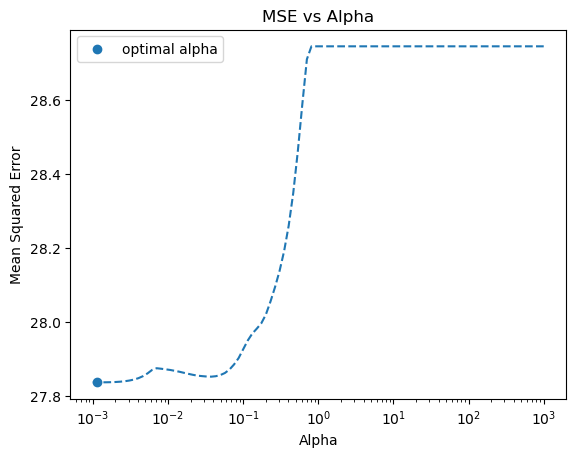

Optimal alpha (Lasso): 0.0011497569953977356


In [15]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fit the transformer only on the training set 
transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)

# Range of alphas (follow log: 0.001 - 1000 normally)
alphas = np.logspace(-3, 3, 100)

# Lasso Cross-validation, 10 folds
lassocv = LassoCV(cv=10, 
                  alphas=alphas, 
                  max_iter=10000, 
                  tol=1e-4, 
                  random_state=404)
lassocv.fit(X_train_norm, y_train)

# mean MSE across folds for each alpha
mse_mean = np.mean(lassocv.mse_path_, axis=1)

# MSE versus alphas
plt.plot(lassocv.alphas_, mse_mean, linestyle='--')
plt.scatter(lassocv.alpha_, mse_mean[np.argmin(mse_mean)], label='optimal alpha')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.legend()
plt.show()

print('Optimal alpha (Lasso):', lassocv.alpha_)

In [16]:
# Lasso Coefficients
lasso_coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lassocv.coef_
})

nonzero_features = lasso_coefficients[lasso_coefficients['coefficient'] != 0]
nonzero_features

,feature,coefficient
0,artist.hotttnesss,0.224256
1,artist_mbtags_count,0.200866
2,bars_confidence,0.061866
3,bars_start,-0.103807
4,beats_confidence,-0.123809
5,beats_start,0.211687
6,duration,3.789252
7,end_of_fade_in,-0.020080
8,familiarity,0.297731
9,key,-0.064845


### Logistic Regression (Baseline)

In [17]:
select_col = lasso_coefficients[lasso_coefficients['coefficient'] != 0]['feature'].to_list()
X = music_numeric[select_col]
y = music_numeric['genre']

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)

log_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_norm, y_train)
log_reg.predict_proba(X_test_norm)

/mnt/home/vuninh/miniconda3/envs/CSE404_h200/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[1.52220022e-02, 1.62787359e-02, 1.60795925e-03, ...,
        3.64887377e-02, 1.08034021e-02, 8.96337918e-02],
       [7.37552266e-03, 2.07254790e-04, 5.89390212e-04, ...,
        2.52619348e-01, 3.25892197e-03, 7.97975213e-03],
       [9.95146440e-04, 6.38065361e-03, 7.46014856e-04, ...,
        3.81927442e-01, 8.86961039e-03, 2.35318059e-03],
       ...,
       [2.74881471e-03, 4.41251814e-02, 4.81613501e-04, ...,
        2.44313106e-01, 7.53252133e-02, 2.60126152e-02],
       [7.30929560e-03, 1.27822435e-02, 5.85050861e-02, ...,
        1.15820080e-02, 1.55142020e-02, 2.38195440e-02],
       [5.97769083e-02, 2.16180504e-03, 8.77850433e-03, ...,
        2.36021923e-01, 2.01184252e-02, 2.33744063e-02]], shape=(2997, 20))

---

#### Graph Neural Networks

##### Graph Structure

<div>
<img src="media/graph.jpg" width="500"/>
</div>

In [18]:
# These will be the three key identifiers
song_id_map = {sid: i for i, sid in enumerate(list(music['song.id']))}                  # There can only be one song
artist_id_map = {aid: i for i, aid in enumerate(list(music['artist.id'].unique()))}     # They can be under the same artist
release_id_map = {aid: i for i, aid in enumerate(list(music['release.id'].unique()))}   # They can be under the same release

In [19]:
all_genres = music['genre'].unique().tolist()

genre_to_idx = {g: i for i, g in enumerate(all_genres)}
num_genres = len(all_genres)

In [20]:
# SONG NODE

song_features = [
    'bars_confidence', 'bars_start', 'beats_confidence', 'beats_start',
    'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
    'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence',
    'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence'
]

num_songs = len(music)
num_song_feats = len(song_features)
song_x = np.zeros((num_songs, num_song_feats), dtype=np.float32)

song_y_list = []

for i, (idx, row) in enumerate(music.iterrows()):
    # Fill in the features
    song_x[i] = row[song_features].values

    genre_str = row['genre']
    label_idx = genre_to_idx[genre_str]
    song_y_list.append(label_idx)

song_x = torch.tensor(song_x, dtype=torch.float32)
song_y = torch.tensor(song_y_list, dtype=torch.long)


In [21]:
### ARTIST NODE ###
artist_features = ['artist.hotttnesss', 'artist_mbtags_count', 'familiarity']
artist_ids = music['artist.id'].unique()
num_artists = len(artist_ids)
artist_x = np.zeros((num_artists, len(artist_features)), dtype=np.float32)

for i, aid in enumerate(artist_ids):
    rows = music[music['artist.id'] == aid].iloc[0]
    artist_x[i] = rows[artist_features].values

artist_x = torch.tensor(artist_x, dtype=torch.float32)

In [22]:
### RELEASE NODE ###
num_releases = len(music['release.id'].unique())
release_x = torch.zeros((num_releases, 1), dtype=torch.float32)

In [23]:
### BUILD EDGES ###

# First row is source idx (artist)
# Second row is the destination (song)

# Artist --> Song

artist_src = []
song_dst = []

for idx, row in music.iterrows():
    s_id = row['song.id']
    a_id = row['artist.id']
    s_idx = song_id_map[s_id]
    a_idx = artist_id_map[a_id]

    artist_src.append(a_idx)
    song_dst.append(s_idx)

artist_song_edge_index = torch.tensor([artist_src, song_dst], dtype=torch.long)


In [24]:
# Release --> Song
release_src = []
song_dst = []

for idx, row in music.iterrows():
    s_id = row['song.id']
    r_id = row['release.id']
    s_idx = song_id_map[s_id]
    r_idx = release_id_map[r_id]

    release_src.append(r_idx)
    song_dst.append(s_idx)

release_song_edge_index = torch.tensor([release_src, song_dst], dtype=torch.long)

In [25]:
artist_src = []
release_dst = []

for idx, row in music.iterrows():
    a_id = row['artist.id']
    r_id = row['release.id']

    a_idx = artist_id_map[a_id]
    r_idx = release_id_map[r_id]

    artist_src.append(a_idx)
    release_dst.append(r_idx)

artist_release_edge_index = torch.tensor([artist_src, release_dst], dtype=torch.long)


In [26]:
data = HeteroData()

data['song'].x = song_x
data['song'].y = song_y

data['artist'].x = artist_x
data['release'].x = release_x

# Artist -> Song
data[('artist', 'creates', 'song')].edge_index = artist_song_edge_index

# Release -> Song
data[('release', 'contains', 'song')].edge_index = release_song_edge_index

# Artist -> Release
data[('artist', 'publishes', 'release')].edge_index = artist_release_edge_index

# Bidirectional,so flipped
data[('song', 'rev_creates', 'artist')].edge_index = data[('artist', 'creates', 'song')].edge_index.flip(0)

data[('song', 'rev_contains', 'release')].edge_index = data[('release', 'contains', 'song')].edge_index.flip(0)

data[('release', 'rev_publishes', 'artist')].edge_index = data[('artist', 'publishes', 'release')].edge_index.flip(0)

metadata = data.metadata()

print(data)
print(f'\n\n{metadata}')


HeteroData(
  song={
    x=[9989, 17],
    y=[9989],
  },
  artist={ x=[3880, 3] },
  release={ x=[8107, 1] },
  (artist, creates, song)={ edge_index=[2, 9989] },
  (release, contains, song)={ edge_index=[2, 9989] },
  (artist, publishes, release)={ edge_index=[2, 9989] },
  (song, rev_creates, artist)={ edge_index=[2, 9989] },
  (song, rev_contains, release)={ edge_index=[2, 9989] },
  (release, rev_publishes, artist)={ edge_index=[2, 9989] }
)


(['song', 'artist', 'release'], [('artist', 'creates', 'song'), ('release', 'contains', 'song'), ('artist', 'publishes', 'release'), ('song', 'rev_creates', 'artist'), ('song', 'rev_contains', 'release'), ('release', 'rev_publishes', 'artist')])


In [27]:
num_songs = data['song'].x.size(0)

indices = np.arange(num_songs)
np.random.shuffle(indices)

train_size = int(0.7 * num_songs)
val_size   = int(0.15 * num_songs)
test_size  = num_songs - train_size - val_size

train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

train_mask = torch.zeros(num_songs, dtype=torch.bool)
val_mask   = torch.zeros(num_songs, dtype=torch.bool)
test_mask  = torch.zeros(num_songs, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data['song'].train_mask = train_mask
data['song'].val_mask   = val_mask
data['song'].test_mask  = test_mask

In [28]:
class HAN(nn.Module):
    def __init__(self, out_channels, hidden_channels=64, heads=8, dropout=0.6):
        super().__init__()
        self.han_conv = HANConv(
            in_channels=-1,         
            out_channels=hidden_channels,
            heads=heads,
            dropout=dropout,
            metadata=data.metadata() 
        )
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        out_dict = self.han_conv(x_dict, edge_index_dict)
        song_emb = out_dict['song']  # [num_songs, hidden_channels]
        song_emb = self.dropout(song_emb)
        logits = self.lin(song_emb)  # [num_songs, out_channels]
        return logits


In [29]:
num_classes = data['song'].y.max().item() + 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HAN(out_channels=num_classes, hidden_channels=64, heads=8, dropout=0.6)
model = model.to(device)

data = data.to(device)


In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

def train():
    model.train()
    optimizer.zero_grad()
    logits = model(data.x_dict, data.edge_index_dict)  # [num_songs, num_classes]

    loss = F.cross_entropy(logits[data['song'].train_mask],
                           data['song'].y[data['song'].train_mask])

    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def evaluate(split='train'):
    model.eval()
    logits = model(data.x_dict, data.edge_index_dict)
    mask = data['song'][f"{split}_mask"]
    pred = logits.argmax(dim=-1)
    correct = (pred[mask] == data['song'].y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc

best_val_acc = 0
patience = 100
temp_patience = patience

for epoch in range(1, 501):
    loss = train()
    train_acc = evaluate('train')
    val_acc   = evaluate('val')
    test_acc  = evaluate('test')

    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
          f"Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

    # Early stopping on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        temp_patience = patience
    else:
        temp_patience -= 1

    if temp_patience <= 0:
        print(f"Early stopping at epoch {epoch}")
        break


Epoch 001, Loss: 3.0854, Train: 0.0360, Val: 0.0401, Test: 0.0274
Epoch 002, Loss: 3.0455, Train: 0.0523, Val: 0.0541, Test: 0.0640
Epoch 003, Loss: 2.9985, Train: 0.0795, Val: 0.0748, Test: 0.0967
Epoch 004, Loss: 2.9802, Train: 0.0737, Val: 0.0688, Test: 0.0941
Epoch 005, Loss: 2.9500, Train: 0.0645, Val: 0.0648, Test: 0.0854
Epoch 006, Loss: 2.9301, Train: 0.0694, Val: 0.0601, Test: 0.0807
Epoch 007, Loss: 2.9237, Train: 0.1399, Val: 0.1335, Test: 0.1348
Epoch 008, Loss: 2.9008, Train: 0.1497, Val: 0.1495, Test: 0.1441
Epoch 009, Loss: 2.8879, Train: 0.1560, Val: 0.1555, Test: 0.1514
Epoch 010, Loss: 2.8758, Train: 0.1600, Val: 0.1602, Test: 0.1568
Epoch 011, Loss: 2.8622, Train: 0.1630, Val: 0.1595, Test: 0.1554
Epoch 012, Loss: 2.8619, Train: 0.1556, Val: 0.1495, Test: 0.1534
Epoch 013, Loss: 2.8583, Train: 0.1499, Val: 0.1422, Test: 0.1568
Epoch 014, Loss: 2.8513, Train: 0.1449, Val: 0.1368, Test: 0.1541
Epoch 015, Loss: 2.8440, Train: 0.1453, Val: 0.1362, Test: 0.1534
Epoch 016,